# Recurrent Neural Networks
Simple Pytorch LSTM

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F

import time

import os

import warnings
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Load the raw data stored in the specified ``csv`` file and inspect the overall data format. Our input is a sequence of closing prices of the stock, and the output is the closing price of the next day. This can be changed

In [55]:
filepath = 'bitcoin.csv'
data = pd.read_csv(os.path.join('../data', filepath))
data = data.sort_values('Date')
data.head()


,Date,Open,High,Low,Close,Volume,Currency
0,2010-07-18,0.0,0.1,0.1,0.1,75,USD
1,2010-07-19,0.1,0.1,0.1,0.1,574,USD
2,2010-07-20,0.1,0.1,0.1,0.1,262,USD
3,2010-07-21,0.1,0.1,0.1,0.1,575,USD
4,2010-07-22,0.1,0.1,0.1,0.1,2160,USD


Plot the raw data.

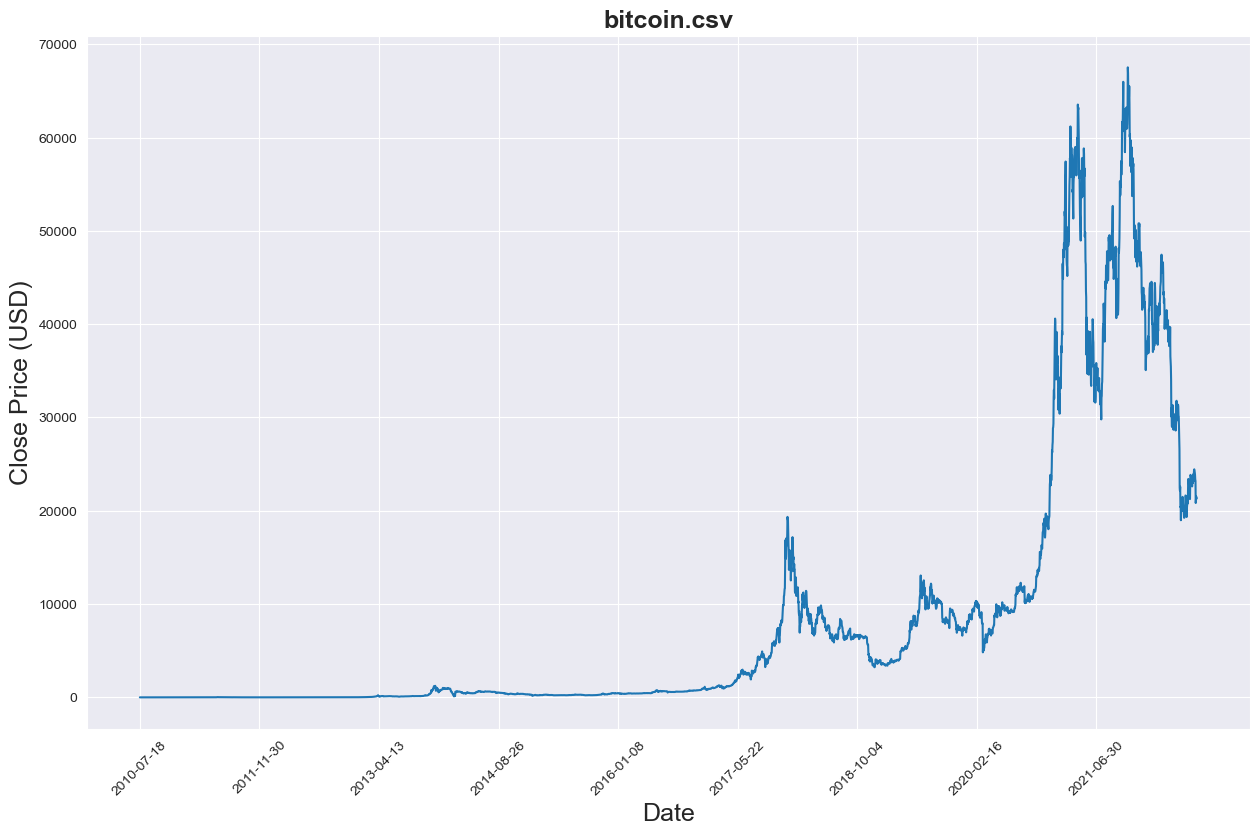

In [56]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title(filepath,fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()


Extract the ``Close`` column in the data frame as our data.

In [57]:
price = data[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4420 entries, 0 to 4419
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4420 non-null   float64
dtypes: float64(1)
memory usage: 34.7 KB


Normalize the raw data into the range of ``[-1, 1]``.

In [58]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/var/folders/g5/dfwv37r13p54dmy66xm4mj3h0000gq/T/ipykernel_36625/2141647733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


The following method helps process the raw data into the desired input and output formats, and at the same time splits the train and test data.

In [59]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]


Call the ``split_data`` function to retrieve ``x_train``, ``y_train``, ``x_test`` and ``y_test``.

In [60]:
# process the raw data
lookback = 20 # choose sequence length
#### START CODE HERE (~1 line) ####
x_train, y_train, x_test, y_test = split_data(price, lookback)
#### END CODE HERE ####
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)


x_train.shape =  (3520, 19, 1)
y_train.shape =  (3520, 1)
x_test.shape =  (880, 19, 1)
y_test.shape =  (880, 1)


Convert from ``numpy.array`` to ``torch.tensor``.

In [61]:
# Convert to torch Tensor
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)
x_train, y_train, x_test, y_test = x_train.float(), y_train.float(), x_test.float(), y_test.float()


Here provides the hyper-parameters for the assignment. You can try changing these hyper-parameters and observe the difference in the model's performance.

In [62]:
# hyper-parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 1
hidden_dim = 64
num_layers = 1
output_dim = 1
num_epochs = 300
learning_rate = 0.01

## Built-in LSTM

1-layer LSTM network using the PyTorch built-in LSTM cell

In [63]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm_cell = nn.LSTMCell(input_dim, hidden_dim, bias=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        ht = torch.zeros(x.size(0), self.hidden_dim).requires_grad_()
        ct = torch.zeros(x.size(0), self.hidden_dim).requires_grad_()

        for t in range(x.shape[1]):
            ht, ct = self.lstm_cell(x[:,t], (ht, ct))
        out = self.fc(ht) 
        return out

In [64]:
lstm_model = LSTM(input_dim, hidden_dim, 1, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

In [65]:
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    y_train_pred = lstm_model(x_train)

    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.9035274982452393
Epoch  1 MSE:  0.5828317403793335
Epoch  2 MSE:  0.21758387982845306
Epoch  3 MSE:  0.1581185907125473
Epoch  4 MSE:  0.00556494714692235
Epoch  5 MSE:  0.03482065349817276
Epoch  6 MSE:  0.05234057828783989
Epoch  7 MSE:  0.04032659903168678
Epoch  8 MSE:  0.01888306997716427
Epoch  9 MSE:  0.006444089580327272
Epoch  10 MSE:  0.010630038566887379
Epoch  11 MSE:  0.021636314690113068
Epoch  12 MSE:  0.02395704574882984
Epoch  13 MSE:  0.016638828441500664
Epoch  14 MSE:  0.008917481638491154
Epoch  15 MSE:  0.00640568183735013
Epoch  16 MSE:  0.008422226645052433
Epoch  17 MSE:  0.011744126677513123
Epoch  18 MSE:  0.013715081848204136
Epoch  19 MSE:  0.01334584690630436
Epoch  20 MSE:  0.01115552056580782
Epoch  21 MSE:  0.008499625138938427
Epoch  22 MSE:  0.006768467370420694
Epoch  23 MSE:  0.006669775582849979
Epoch  24 MSE:  0.007869026623666286
Epoch  25 MSE:  0.009257891215384007
Epoch  26 MSE:  0.009765207767486572
Epoch  27 MSE:  0.009103083

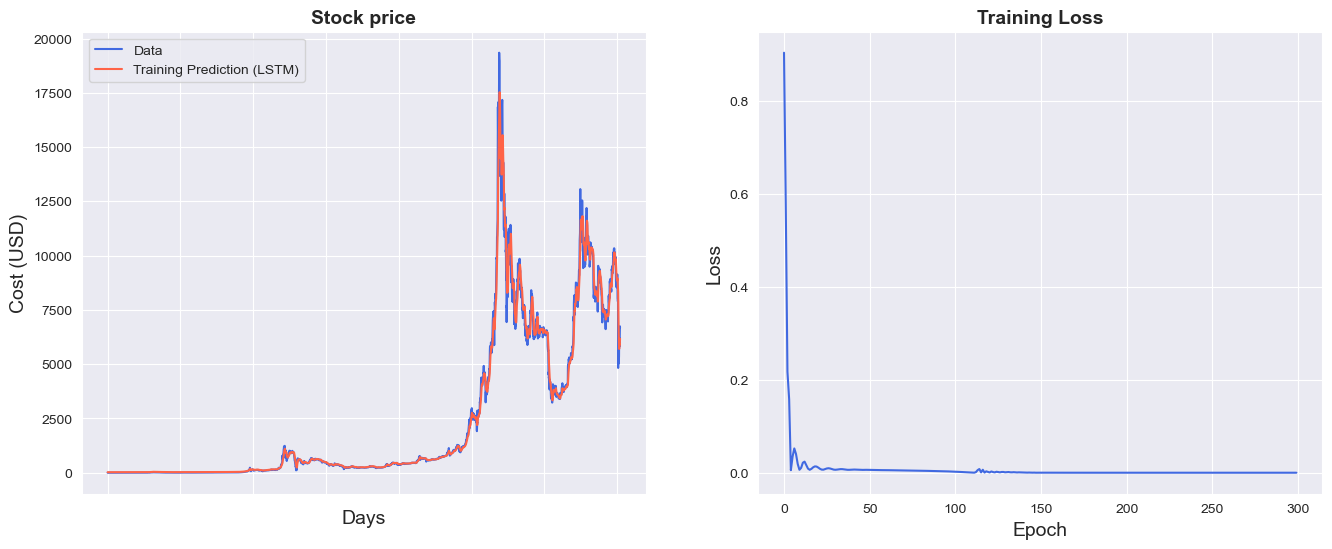

In [66]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().cpu().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().cpu().numpy()))

sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)


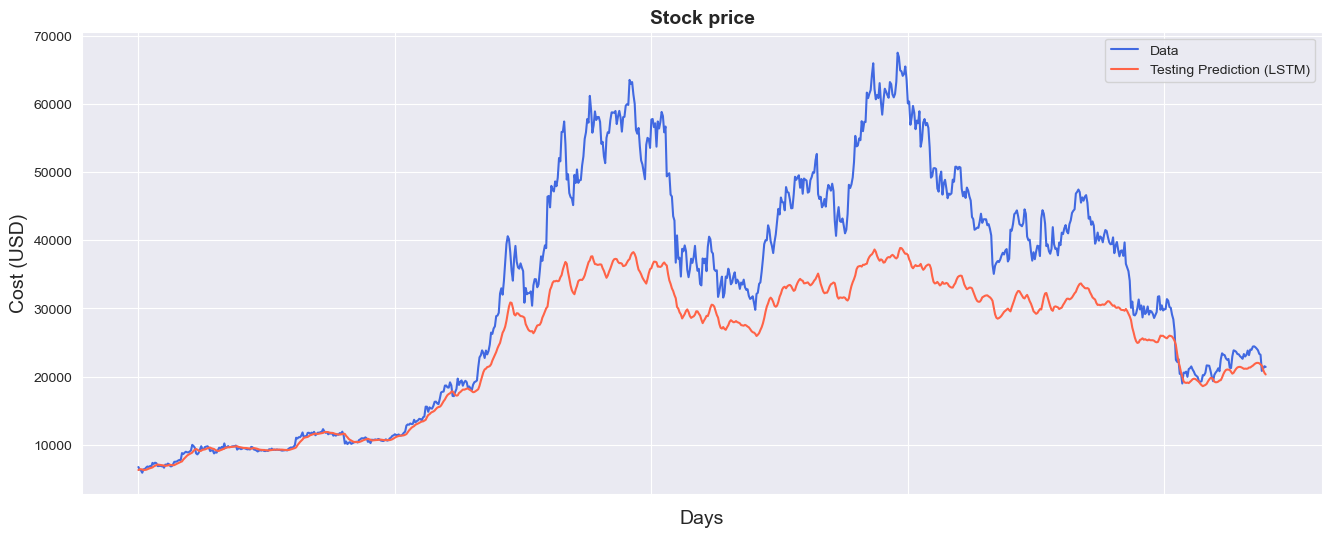

In [67]:
# make predictions
with torch.no_grad():
    x_test = x_test.to(device)
    y_test_pred = lstm_model(x_test)

predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().cpu().numpy()))
original_test = pd.DataFrame(scaler.inverse_transform(y_test.detach().cpu().numpy()))

sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = original_test.index, y = original_test[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict_test.index, y = predict_test[0], label="Testing Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

fig.set_figheight(6)
fig.set_figwidth(16)

In [68]:
# calculate root mean squared error
y_train2 = y_train.detach().cpu().numpy()
y_train_pred = y_train_pred.detach().cpu().numpy()
trainScore = np.sqrt(metrics.mean_squared_error(y_train2[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

y_test2 = y_test.detach().cpu().numpy()
y_test_pred = y_test_pred.detach().cpu().numpy()
testScore = np.sqrt(metrics.mean_squared_error(y_test2[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.01 RMSE
Test Score: 0.33 RMSE


## Built-in GRU

1-layer GRU network using the PyTorch built-in GRU cell.

In [69]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru_cell = nn.GRUCell(input_dim, hidden_dim, bias=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        ht = torch.zeros(x.size(0), self.hidden_dim).requires_grad_()

        for t in range(x.shape[1]):
            ht = self.gru_cell(x[:,t], ht)
        out = self.fc(ht) 
        return out

In [70]:
gru_model = GRU(input_dim, hidden_dim, 1, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)

In [71]:
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    y_train_pred = gru_model(x_train)

    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  1.0589511394500732
Epoch  1 MSE:  0.556174635887146
Epoch  2 MSE:  0.19928885996341705
Epoch  3 MSE:  0.006554410792887211
Epoch  4 MSE:  0.32702428102493286
Epoch  5 MSE:  0.038140103220939636
Epoch  6 MSE:  0.01516782771795988
Epoch  7 MSE:  0.06393852829933167
Epoch  8 MSE:  0.09842120110988617
Epoch  9 MSE:  0.10501698404550552
Epoch  10 MSE:  0.08958043158054352
Epoch  11 MSE:  0.062259986996650696
Epoch  12 MSE:  0.03346586227416992
Epoch  13 MSE:  0.012401950545608997
Epoch  14 MSE:  0.005277485586702824
Epoch  15 MSE:  0.012493833899497986
Epoch  16 MSE:  0.02679561637341976
Epoch  17 MSE:  0.03683106601238251
Epoch  18 MSE:  0.03579507768154144
Epoch  19 MSE:  0.025894613936543465
Epoch  20 MSE:  0.014234275557100773
Epoch  21 MSE:  0.006621434818953276
Epoch  22 MSE:  0.004921718966215849
Epoch  23 MSE:  0.007753121666610241
Epoch  24 MSE:  0.012303737923502922
Epoch  25 MSE:  0.01592309959232807
Epoch  26 MSE:  0.017066694796085358
Epoch  27 MSE:  0.0155393602

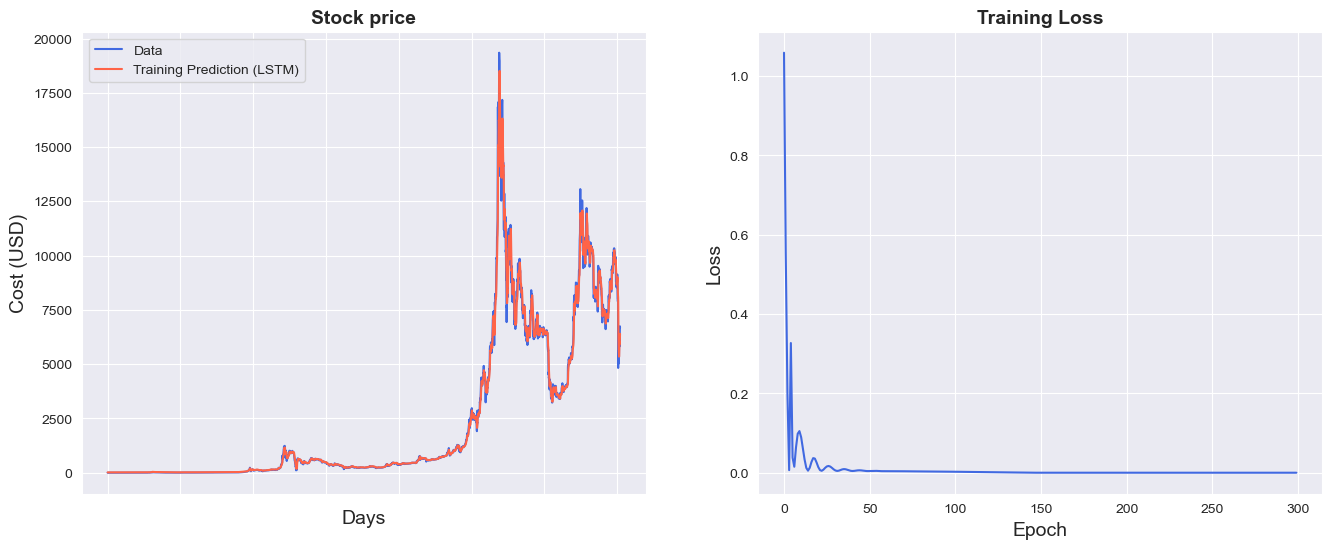

In [72]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().cpu().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().cpu().numpy()))

sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

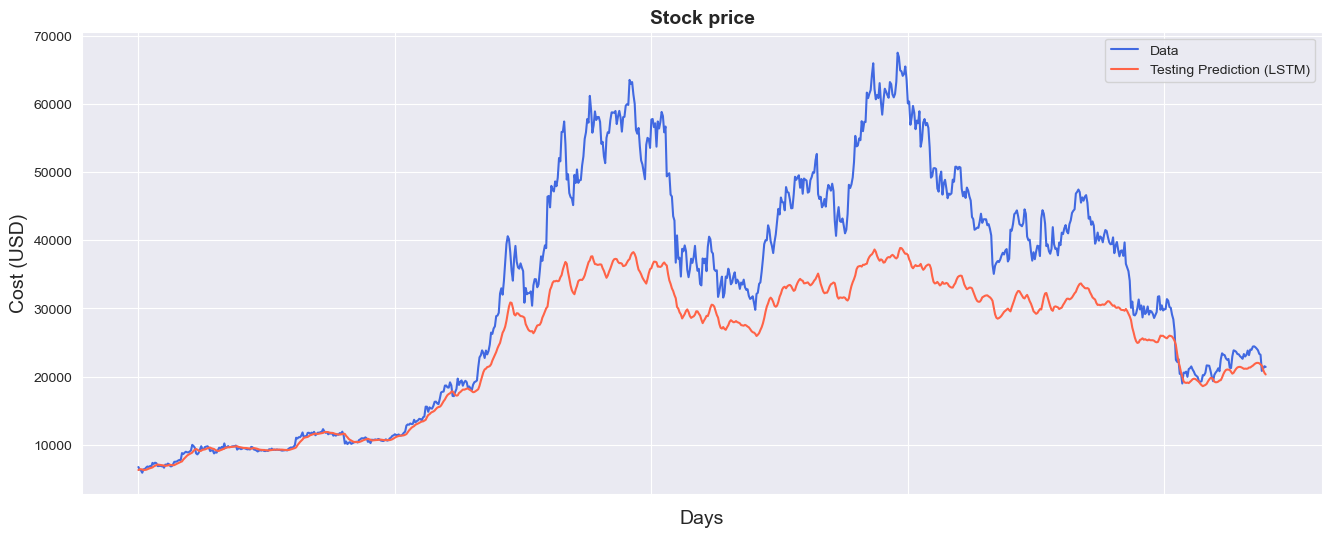

In [73]:
# make predictions
with torch.no_grad():
    x_test = x_test.to(device)
    y_test_pred = lstm_model(x_test)

predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().cpu().numpy()))
original_test = pd.DataFrame(scaler.inverse_transform(y_test.detach().cpu().numpy()))

sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = original_test.index, y = original_test[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict_test.index, y = predict_test[0], label="Testing Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

fig.set_figheight(6)
fig.set_figwidth(16)

In [74]:
# calculate root mean squared error
y_train2 = y_train.detach().cpu().numpy()
y_train_pred = y_train_pred.detach().cpu().numpy()
trainScore = np.sqrt(metrics.mean_squared_error(y_train2[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

y_test2 = y_test.detach().cpu().numpy()
y_test_pred = y_test_pred.detach().cpu().numpy()
testScore = np.sqrt(metrics.mean_squared_error(y_test2[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.01 RMSE
Test Score: 0.33 RMSE
